### ToDo
* changing resource state 
* changing setup for each op 
    * may not required as you have the current operation with the req setup
    * and we do not consider setup times.
* monitoring the basics
* Material (Charge, Qualität, usw)
* Vorgänger (und Nachfolger) auf der Maschine speichern (vollständige Historie) --> Erweiterung: Stack/Queue mit "x Elementen" oder einen "x Zeitraum"
* alternative Maschine aus Maschinengruppe nutzen (optional?)
* Giffler - offene Operationen für die Inferencing
* run-event selbst bauen warten bis zum Endschritt 


Wie macht man Effekte sichtbar?
Qualitätsstufen von Materialen

In [4]:
from causal.causal_model_causal_non_causal import CausalModelCBN
from plan.GifflerThompson import GifflerThompson
from plan.HodgsonMoore import HodgsonMooreAlgorithm
from factory.Operation import Operation
from simulation.Simulator import Simulator
from causal.causal_model import CausalModel
from generators.jobs_data_generator import JobsDataGenerator
import random

import pandas as pd
# Beispielhafte Datenstruktur
template_jobs_data = [
    ['p1', 1, 'a1', 1, 30, 4],
    ['p1', 2, 'a2', 1, 45, 4],
    ['p1', 3, 'a1', 2, 15, 4],
    ['p1', 4, 'a3', 1, 15, -1],
    ['p2', 1, 'a1', 1, 15, 3],
    ['p2', 2, 'a4', 2, 45, 3],
    ['p2', 3, 'a3', 2, 15, 5],
    ['p2', 4, 'a2', 1, 30, 5],
    ['p2', 5, 'a4', 1, 15, -1],
    
#    ['p1', 1, 'a1', 17, 2],
#    ['p1', 2, 'a2', 30, 4],
#    ['p1', 3, 'a3', 14, 4],
#    ['p1', 4, 'a4', 15, 5],
#    ['p1', 5, 'a5', 25, -1],
#    ['p2', 1, 'a1', 13, 3],
#    ['p2', 2, 'a3', 15, 3],
#    ['p2', 3, 'a2', 10, 4],
#    ['p2', 4, 'a6', 20, -1],
]

generator = JobsDataGenerator(template_jobs_data)
num_instances = 150  # Number of new instances to generate
relation = {'p1': 0.5, 'p2': 0.5}  # Relation of each product type

jobs_data = generator.generate_jobs_data(num_instances, relation)

# Maschinenpools definieren
# id, number, tools 
machine_pools_data = [
    ['a1', 1, [1,2,3]],
    ['a2', 1, [1,2,3]],
    ['a3', 1, [1,2,3]],
    ['a4', 1, [1,2,3]],
#    ['a5', 1, [1,2,3]],
#    ['a6', 1, [1,2,3]],
]

# Konvertiere die jobs_data in Operation-Objekte
operations_causal = [Operation(*data) for data in jobs_data]
operations_non_causal = [Operation(*data) for data in jobs_data]

# Define a priority rule
def calculate_dynamic_priority(operation) -> int:
    # Priorität basierend auf der geplanten Startzeit der Vorgängeraufgaben
    if not operation.predecessor_operations:
        return operation.plan_start if operation.plan_start is not None else 0
    else:
        return max(pred.plan_start for pred in operation.predecessor_operations) + operation.duration

# Define a priority rule
def calculate_fcfs_priority(operation) -> int:
     """
     Calculate the First-Come-First-Serve (FCFS) priority for the given operation.
     
     Parameters:
     operation (Operation): The operation object which contains information like planned start time.
     
     Returns:
     int: The priority value based on the FCFS rule (lower value means higher priority).
     """
     # Use the planned start time as the FCFS priority, assuming earlier times have higher priority.
     # If plan_start is None, return a large number to deprioritize unscheduled operations.
     return operation.plan_start if operation.plan_start is not None else float('inf')


# causal model
observed_data = []
csv_file = 'data/observed_data.csv'
#model = CausalModel(csv_file=csv_file)
#model = CausalModelPyMC(csv_file=csv_file)
model = CausalModelCBN()
# Causal model for simulation
# define an inference rule    
def simulation_inference(operation: Operation, tool) -> int:
 
    # 1. Preperation step
    #has_lots_operations = len(operation.predecessor_operations) > 1
    #is_shorter_than_15 =  operation.plan_duration < 15
    #filtered_pools = [pool for pool in sim.pools.values() if pool.group == operation.machine.group and pool.id != operation.machine.id]
    #one_working = any(pool.current_operation is not None for pool in filtered_pools) 
    
    # 2. Infer step
    inferenced_variables = model.infer_duration(True, operation, tool)

    # 3. Calculation step
    new_duration = round(operation.duration * inferenced_variables['delay'],0)
    
    # Save for causal learning
    observed_data.append([tool, inferenced_variables['machine_status'], inferenced_variables['pre_processing'], inferenced_variables['delay']])
    #observed_data.append([len(operation.predecessor_operations), operation.req_machine_group_id, duration_factor])
    
    print(f"Operation duration was: {operation.duration} and has been changed to {new_duration}")
    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference(operation: Operation, tool) -> int:
        
    # 2. Infer step
    inferenced_variables = model.infer_duration(False, operation, tool)

    new_duration = round(operation.duration * inferenced_variables['delay'],0)

    return new_duration

# Causal model for planning
# define an inference rule
def plan_inference_non(operation: Operation, tool) -> int:
    return operation.duration

#hodgens = HodgsonMooreAlgorithm()
#hodgens_schedule = hodgens.schedule_jobs(operations_non_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
gt = GifflerThompson(calculate_dynamic_priority, plan_inference)
gt_causal_schedule = gt.giffen_thompson(operations_causal, machine_pools_data)

# Führe den Giffler Thompson Algorithmus aus
non_causal = GifflerThompson(calculate_dynamic_priority, plan_inference_non)
gt_non_causal_schedule = non_causal.giffen_thompson(operations_non_causal, machine_pools_data)


Set edges by user
Testing combination: Algorithm=hill_climb, Score=BDeu
Lerne Modell mit hill_climb-Algorithmus und BDeu-Score


  0%|          | 4/1000000 [00:00<32:41:10,  8.50it/s]


Successful combination: Algorithm=hill_climb, Score=BDeu
Testing combination: Algorithm=hill_climb, Score=Bic
Lerne Modell mit hill_climb-Algorithmus und Bic-Score


  0%|          | 4/1000000 [00:00<31:07:12,  8.93it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=Bic
Testing combination: Algorithm=hill_climb, Score=K2
Lerne Modell mit hill_climb-Algorithmus und K2-Score


  0%|          | 9/1000000 [00:00<22:02:45, 12.60it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=K2
Testing combination: Algorithm=hill_climb, Score=StructureScore
Lerne Modell mit hill_climb-Algorithmus und StructureScore-Score


  0%|          | 0/1000000 [00:00<?, ?it/s]


Error with combination Algorithm=hill_climb, Score=StructureScore: 'StructureScore' object has no attribute 'local_score'
Testing combination: Algorithm=hill_climb, Score=BDsScore
Lerne Modell mit hill_climb-Algorithmus und BDsScore-Score


  0%|          | 4/1000000 [00:00<32:15:13,  8.61it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=BDsScore
Testing combination: Algorithm=hill_climb, Score=AICScore
Lerne Modell mit hill_climb-Algorithmus und AICScore-Score


  0%|          | 4/1000000 [00:00<31:25:40,  8.84it/s]


Learned model does not represent truth model
Failed combination: Algorithm=hill_climb, Score=AICScore
Testing combination: Algorithm=tree_search, Score=BDeu
Lerne Modell mit tree_search-Algorithmus und BDeu-Score
Error with combination Algorithm=tree_search, Score=BDeu: TreeSearch.estimate() got an unexpected keyword argument 'scoring_method'
Testing combination: Algorithm=tree_search, Score=Bic
Lerne Modell mit tree_search-Algorithmus und Bic-Score
Error with combination Algorithm=tree_search, Score=Bic: TreeSearch.estimate() got an unexpected keyword argument 'scoring_method'
Testing combination: Algorithm=tree_search, Score=K2
Lerne Modell mit tree_search-Algorithmus und K2-Score
Error with combination Algorithm=tree_search, Score=K2: TreeSearch.estimate() got an unexpected keyword argument 'scoring_method'
Testing combination: Algorithm=tree_search, Score=StructureScore
Lerne Modell mit tree_search-Algorithmus und StructureScore-Score
Error with combination Algorithm=tree_search, S

Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 17.41it/s]


Failed combination: Algorithm=pc, Score=BDeu
Testing combination: Algorithm=pc, Score=Bic
Lerne Modell mit pc-Algorithmus und Bic-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 18.44it/s]


Failed combination: Algorithm=pc, Score=Bic
Testing combination: Algorithm=pc, Score=K2
Lerne Modell mit pc-Algorithmus und K2-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 18.34it/s]


Failed combination: Algorithm=pc, Score=K2
Testing combination: Algorithm=pc, Score=StructureScore
Lerne Modell mit pc-Algorithmus und StructureScore-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 18.43it/s]


Failed combination: Algorithm=pc, Score=StructureScore
Testing combination: Algorithm=pc, Score=BDsScore
Lerne Modell mit pc-Algorithmus und BDsScore-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 18.27it/s]


Failed combination: Algorithm=pc, Score=BDsScore
Testing combination: Algorithm=pc, Score=AICScore
Lerne Modell mit pc-Algorithmus und AICScore-Score


Working for n conditional variables: 4:  80%|████████  | 4/5 [00:00<00:00, 18.48it/s]


Failed combination: Algorithm=pc, Score=AICScore
successful_combinations 1
Lerne Modell mit hill_climb-Algorithmus und BDeu-Score


  0%|          | 4/1000000 [00:00<32:23:54,  8.57it/s]


In [5]:
from simulation.Simulator import Simulator
from simulation.Monitoring.BasicMonitor import monitorResource
from functools import partial

# array to store monitored data
data = []

# resource monitor [pre , post] execution
monitor = [None, partial(monitorResource, data)]

sim = Simulator(machine_pools_data
                , operations_non_causal
                , monitor
                , simulation_inference)

sim.env.run(12000)

2430
2925
2550
2970
2835
1485
2895
3450
3525
3120
3750
3180
3795
3435
2070
3465
4245
4275
3750
2385
3810
4650
4680
4035
4950
4095
4995
4380
5385
4500
5430
45
0
60
180
3015
390
225
405
585
3105
705
915
825
960
1080
1335
1170
1380
1455
855
1485
1845
3330
1770
2190
1890
2235
1905
2280
1935
2325
1950
2325
1980
2370
1995
1125
2040
2370
3390
2010
2400
2040
2445
2055
1170
2115
2445
3405
2070
2475
2100
2520
2115
1215
2160
2520
3420
2130
2550
2160
2595
2175
2595
2205
2640
2220
2640
2250
2685
2265
2685
2295
2730
2310
1260
2340
2730
3435
2325
2760
2355
2805
2370
1305
2385
2805
3450
2385
2835
2415
2880
2460
2880
2490
2925
2505
2970
2535
3015
2565
3015
2595
3075
2610
1350
2655
3060
3465
2625
1395
2670
3090
3480
2640
1440
2700
3120
3495
2655
3150
2685
3195
2700
3195
2730
3240
2745
3240
2775
3285
2790
3285
2820
3330
2850
3330
2880
3375
2895
1530
2940
3375
3510
2910
3405
2940
3450
2955
1575
2985
3480
3540
2970
1620
3030
3510
3555
2985
1665
3045
3540
3570
3000
1710
3060
3570
3600
3015
3600
3045
3645
30

## Some statistics to compare the plan

In [6]:
import pandas as pd

def calculate_makespan(df_schedule, schedule_name):
    # Convert the list of operation objects to a DataFrame
    

    # Calculate start and end times for each job
    grouped_schedule = df_schedule.groupby('job_id').agg({'start_time': 'min', 'end_time': 'max'})

    # Calculate the makespan for each job
    grouped_schedule['makespan'] = grouped_schedule['end_time'] - grouped_schedule['start_time']

    # Calculate the average makespan across all jobs
    average_makespan = grouped_schedule['makespan'].mean()

    # Output the results with the schedule name
    print(f"{schedule_name} | {average_makespan} time units")

print(f"Average makespan across all products: ")
# Example usage with named schedules
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_non_causal_schedule]), 'NonCausal')
calculate_makespan(pd.DataFrame([op.to_dict() for op in gt_causal_schedule]), 'Causal')
calculate_makespan(pd.DataFrame([op.to_dict_sim() for op in sim.schedule]), 'Sim')


Average makespan across all products: 
NonCausal | 1360.0 time units
Causal | 1486.3 time units
Sim | 1517.2 time units


In [7]:
df_observed_data = pd.DataFrame(observed_data, columns=['previous_machine_pause' , 'machine_status', 'pre_processing', 'operation_duration'])
df_observed_data.to_csv("data/observed_data.csv")

GT without causal

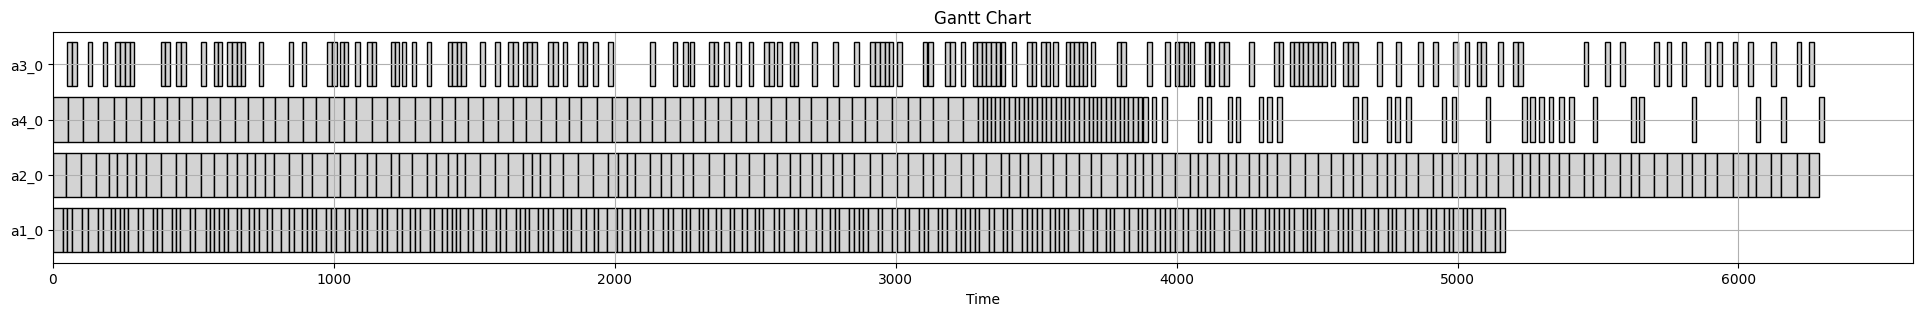

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


Sim result

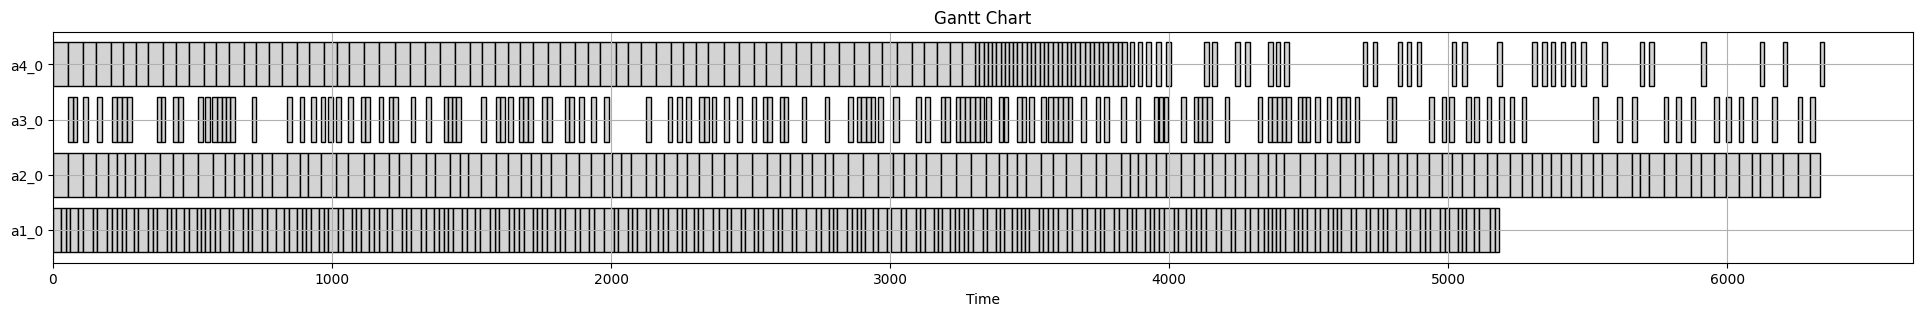

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([op.to_dict_sim() for op in sim.schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()


GT with Causal

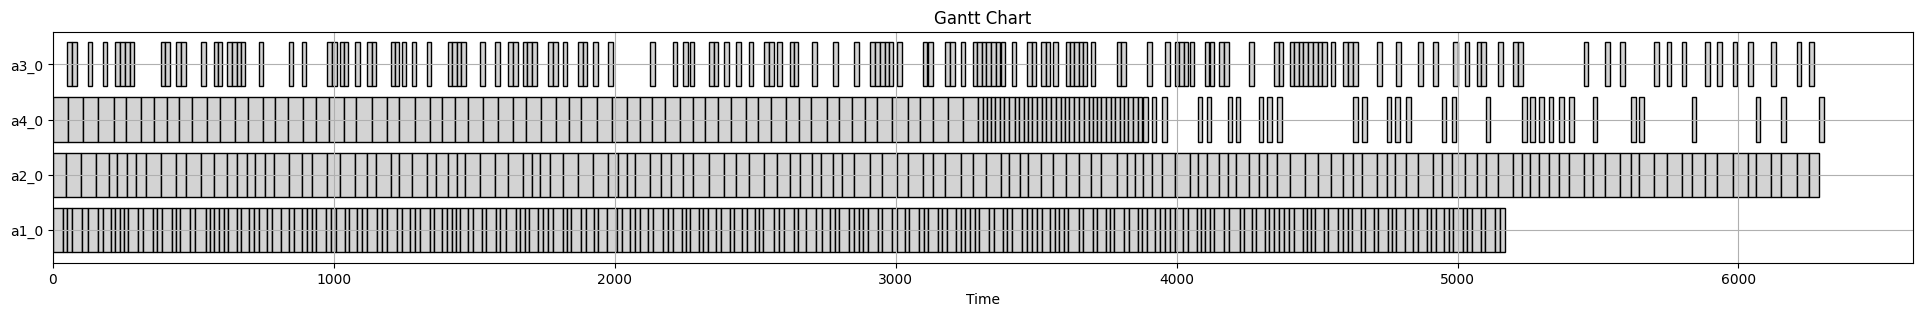

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import math

# Daten in ein DataFrame konvertieren
df = pd.DataFrame([p.to_dict() for p in gt_causal_schedule])

size_height = math.ceil(df["machine"].count().itemsize / 3)
# Gantt-Diagramm erstellen
fig, ax = plt.subplots(figsize=(24, size_height))

# Maschinen als y-Werte für die Balken
machines = df['machine'].unique()
machine_to_y = {machine: i for i, machine in enumerate(machines)}

# Iteriere über jede Zeile des DataFrames
for i, row in df.iterrows():
    start = row['start_time']
    duration = row['plan_duration']
    job_id = row['job_id']
    task_id = row['operation_id']
    machine = row['machine']
    label = f'{job_id} {task_id}'

    # Stelle die Aufgabe als Balken im Diagramm dar
    ax.barh(y=machine_to_y[machine], left=start, width=duration, height=0.8, align='center', color='lightgrey', edgecolor='black')
    
    # Text in den Balken einfügen
    #ax.text(x=start + duration / 2, y=machine_to_y[machine], s=label, va='center', ha='center', color='black')

# Diagramm formatieren
ax.set_xlabel('Time')
ax.set_yticks(list(machine_to_y.values()))
ax.set_yticklabels(list(machine_to_y.keys()))
ax.set_title('Gantt Chart')

# Grid anzeigen
ax.grid(True)

# Legende entfernen, da sie nicht mehr notwendig ist
# Handles und Labels der Legende deduplizieren
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# plt.legend(by_label.values(), by_label.keys())

# Diagramm anzeigen
plt.show()
